In [1]:
import os
import re
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import plotly.express as px

#Setup NLTK
!pip install --user -U nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
#downloading the twitter data
!gdown 11LWo5nagSmC72hOJM9lm2l05sdQxt4rf

Downloading...
From: https://drive.google.com/uc?id=11LWo5nagSmC72hOJM9lm2l05sdQxt4rf
To: /content/corona_tweets.csv
100% 1.00M/1.00M [00:00<00:00, 80.1MB/s]


In [3]:
#reading the downloaded csv file into a dataframe
df = pd.read_csv("./corona_tweets.csv")
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [4]:
#checking all the Sentiments we have. Going further in our problem statement, we will only consider Positive and Negative sentiments for ease
df.Sentiment.unique()

array(['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative',
       'Neutral'], dtype=object)

In [5]:
df.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

Sentiments in the dataset:  ['Extremely Negative' 'Positive' 'Extremely Positive' 'Negative' 'Neutral']
Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64


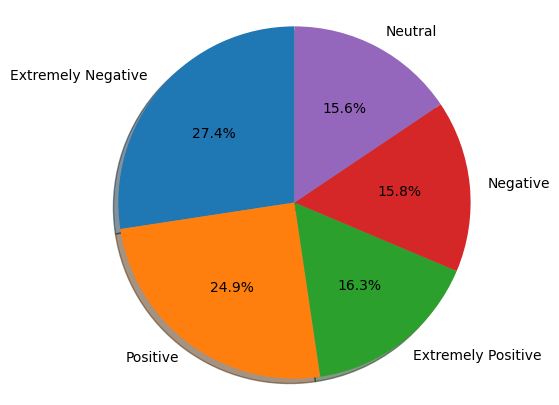

In [5]:
#function to plot the sentiments by count of tweets
def pie_chart(df):
  #converting object type to string type for each label
  label_types = df.Sentiment.unique().astype(str)
  #count of tweets for each type of sentiment
  label_counts = df.Sentiment.value_counts()
  print('Sentiments in the dataset: ', label_types)
  print(label_counts)
  sizes = [count for count in label_counts]
  fig = plt.figure(figsize=(5,5))
  plt.pie(sizes, labels=label_types, autopct='%1.1f%%', shadow=True, startangle=90)
  plt.axis('equal')
  plt.show()

pie_chart(df)

In [6]:
#Separating positive tweets and negative tweets. (consider only positive and negative tweets in this problem)
all_positive_tweets = list(df[df['Sentiment'] == 'Positive']['OriginalTweet'].astype(str))
all_negative_tweets = list(df[df['Sentiment'] == 'Negative']['OriginalTweet'].astype(str))[:947]

#Splitting train and test sets. 80/20 split
positive_train, positive_test = train_test_split(all_positive_tweets, test_size=0.2, random_state=42)
negative_train, negative_test = train_test_split(all_negative_tweets, test_size=0.2, random_state=42)

print("Size of training dataset: ", len(positive_train) + len(negative_train))
print("Size of testing dataset: ", len(positive_test) + len(negative_test))

print('\033[92m' +'\nExample for positive tweet:')
print( all_positive_tweets[random.randint(0,947)])
print('\033[91m' +'\nExample for negative tweet:')
print( all_negative_tweets[random.randint(0,947)])

Size of training dataset:  1514
Size of testing dataset:  380

Example for positive tweet:






Potatoes, rice, good long lasting food. Stock up.

Example for negative tweet:
Real question, should I stock up on things I already have (dog food, cat food, litter, tampons, etc.)? How insane is this #coronavirus thing going to get? Im not worried about the virus, Im worried about being told to stay put with no supplies...


In [7]:
import nltk                           # Python library for NLP
from nltk.stem import PorterStemmer   # module for stemming
from nltk.corpus import stopwords     # module for stop words that come with
from nltk.tokenize import TweetTokenizer #method in nltk to tokenize tweets.

# Import the english stop words list from NLTK
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Preprocessing the Tweet data**

In [8]:
#function to process the tweet. Called multiple times where ever processing of tweet is needed.
def process_tweet(tweet):
  stemmer = PorterStemmer()
  stopwords_english = stopwords.words('english')
  #removing stock market symbols like $GE
  tweet = re.sub(r'\$\w*', '', tweet)
  #remove old style retweet text "RT"
  tweet = re.sub(r'^RT[\s]+', '', tweet)
  #remove hyperlinks
  tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
  #remove hashtags '#' sign from the word
  tweet = re.sub(r'#', '', tweet)
  #tokenize tweets
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet)

  tweets_clean = []
  for word in tweet_tokens:
    if (word not in stopwords_english and  #remove stopwords
          word not in string.punctuation):  #remove punctuations
      stem_word = stemmer.stem(word)  # stemming words
      tweets_clean.append(stem_word)

  return tweets_clean


In [9]:
#check the above method with a sample tweet
tweet = all_positive_tweets[12]

print()
print(tweet)

#pass the tweet to the function - 'process_tweet'
tweets_stem = process_tweet(tweet); #preprocess the given tweet

print('Preprocessed tweet: ')
print(tweets_stem)


Consumers have increased their online shopping due to coronavirus. https://t.co/5mYfz3RAD0 #retail #ecommerce #study #coronavirus https://t.co/Dz3H6zrWUT
Preprocessed tweet: 
['consum', 'increas', 'onlin', 'shop', 'due', 'coronaviru', 'retail', 'ecommerc', 'studi', 'coronaviru']


**Representing BOW/vocab list in 3 dimensions**

In [17]:
#function to build a frequency dictionary
def build_freqs(tweets, ys):
  """
      tweets: a list of tweets
      ys: an m x 1 array with the sentiment label of each tweet
          (either 0 or 1)
      freqs: a dictionary mapping each (word, sentiment) pair (=key) to its frequency (=value)
  """
  #Convert np array to list since zip needs an iterable.
  #The squeeze is necessary or the list ends up with one element.
  yslist = np.squeeze(ys).tolist()
  i = 1
  print(yslist)

  #Start with an empty dictionary and populate it by looping over all tweets
  #and over all processed words in each tweet
  freqs = {}
  for y, tweet in zip(yslist, tweets):
    #debugging
    if (i==100):
      print(y, tweet)
    for word in process_tweet(tweet):
      pair = (word, y)
      if pair in freqs:
        freqs[pair] += 1
      else:
        freqs[pair] = 1
    i += 1
    #debugging
    if (i == 10) :
      print(freqs)
      i += 1

  return freqs


In [11]:
training_tweets = positive_train + negative_train
#make a numpy array representing labels of the tweets
labels = np.append(np.ones(len(positive_train)), np.zeros(len(negative_train)))


In [18]:
#create frequency dictionary
freqs = build_freqs(training_tweets, labels)

#check data type
print(f'type(freqs) = {type(freqs)}')

#check length of the dictionary
print(f'len(frwqs) = {len(freqs)}')

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [13]:
# select some words to appear in the report.
keys = ['void', 'commun', 'spirit', 'stop', 'merri', 'nice', 'good', 'bad', 'sad', 'mad', 'best', 'pretti',
        ':)', ':(', 'song', 'idea', 'power', 'play']

#list representing our table of word counts
# each element consist of a sublist with this pattern: [<word>, <positive_count>, <negative_count>]
data = []

#loop through our selected words
for word in keys:

  #initialize positive and negative counts
  pos = 0
  neg = 0

  #retrieve number of positive counts
  if (word,1) in freqs:
    pos = freqs[(word, 1)]

  #retrieve number of negative counts
  if (word,0) in freqs:
    neg = freqs[(word, 0)]

  #append the word counts to the table
  data.append([word, pos, neg])

data

[['void', 1, 0],
 ['commun', 15, 10],
 ['spirit', 1, 2],
 ['stop', 14, 32],
 ['merri', 0, 0],
 ['nice', 6, 6],
 ['good', 49, 28],
 ['bad', 1, 8],
 ['sad', 0, 5],
 ['mad', 2, 8],
 ['best', 7, 3],
 ['pretti', 6, 3],
 [':)', 1, 1],
 [':(', 3, 0],
 ['song', 2, 0],
 ['idea', 6, 8],
 ['power', 5, 0],
 ['play', 8, 1]]

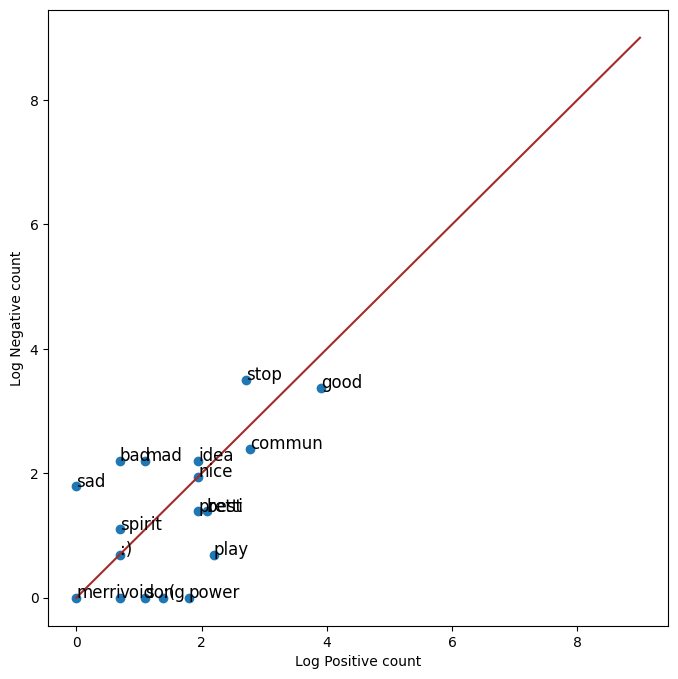

In [14]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])

#do the same for the negative counts
y = np.log([x[2] + 1 for x in data])

#Plot a dot for each pair of words
ax.scatter(x, y)

#assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

#Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
  ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'brown') # Plot the red line that divides the 2 areas.
plt.show()

[1, 15, 1, 14, 0, 6, 49, 1, 0, 2, 7, 6, 1, 3, 2, 6, 5, 8]

Extracting Features

In [26]:
def extract_features(tweet, freqs):
  '''
    tweet: a list of words for one tweet
    freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    x: a feature vector of dimension (1,3)
  '''
  #process_tweet processes the tweet - it tokenized, stems and removes stopwords
  word_tokens = process_tweet(tweet)
  #3 elements in the form of a 1*3 vector
  x = np.zeros((1, 3))
  #print(x)
  #bias term is set to 0
  x[0, 0] = 1
  #print(x)
  #loop through each word in the list of words
  for word in word_tokens:
    #increment the word count for the positive label 1
    #print(freqs.get((word, 1.0), 0))
    x[0, 1] += freqs.get((word, 1.0), 0)
    # increment the word count for the negative label 0
    #freqs.get((word, 0.0), 0)
    x[0,2] += freqs.get((word, 0.0),0)
  #print(x)
  assert(x.shape == (1,3))
  return x


Example1 : Feature extraction for a tweet

In [27]:
train_x = training_tweets
tmp1 = extract_features(train_x[0], freqs)
print(tmp1)

[[1.000e+00 2.284e+03 2.482e+03]]


In [24]:
# train_x = training_tweets
# tmp1 = extract_features(train_x[0], freqs)
# print(tmp1)

[[0. 0. 0.]]
[[1. 0. 0.]]
78
18
9
97
92
21
146
1
78
4
14
10
8
1
16
17
562
218
39
562
290
2
1
[[1.000e+00 2.284e+03 2.482e+03]]
[[1.000e+00 2.284e+03 2.482e+03]]


2284.0

Example2: Feature extraction for a random string

In [28]:
tmp2 = extract_features('This batch is the best batch', freqs)
print(tmp2)

[[ 1. 11.  3.]]


#Prepare training data

In [35]:
#collect the features and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
  X[i, :] = extract_features(train_x[i], freqs)

#training labels corresponding to X
train_y = np.append(np.ones((len(positive_train), 1)), np.zeros((len(negative_train), 1)), axis=0)
#print(train_y)
Y = np.ravel(train_y, order='C')
#print(Y)

Applying basic classification model - Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
clf = model.fit(X, Y)

print("Training Accuracy: ", clf.score(X, Y))

Training Accuracy:  0.678996036988111


Check performance on test set

In [38]:
#Testing
testing_tweets = positive_test + negative_test

test_X = np.zeros((len(testing_tweets), 3))
for i in range(len(testing_tweets)):
  test_X[i, :] = extract_features(testing_tweets[i], freqs)

#labels corresponding to test_X
test_y = np.append(np.ones((len(positive_test), 1)), np.zeros((len(negative_test), 1)))
test_Y = np.ravel(test_y, order='C')

print("Test Accuracy: ", clf.score(test_X, test_Y))

Test Accuracy:  0.55


Predict whether a given tweet is positive or negative

In [39]:
def predict_custom_tweet(tweet, freqs):
  x = extract_features(tweet, freqs)
  y_pred = clf.predict(x)
  return y_pred

#test your function with some tweets
list_of_tweets = ['\033[92m'+'Thank God coronovirus is over',
                  '\033[91m'+'This is seriously ridiculous. Stop hoarding',
                  '\033[92m'+'Government efforts are great.',
                  '\033[93m'+'Nonsense', #anomaly in classification
                  '\033[91m'+'Panic-buying is pushing up prices.#coronavirus',
                  '\033[92m'+'THANK YOU to make hand sanitizer in distillery amid outbreak']

for tweet in list_of_tweets:
  print( '%s -> %f' %(tweet, predict_custom_tweet(tweet, freqs)))

Thank God coronovirus is over -> 1.000000
This is seriously ridiculous. Stop hoarding -> 0.000000
Government efforts are great. -> 1.000000
Nonsense -> 1.000000
Panic-buying is pushing up prices.#coronavirus -> 0.000000
THANK YOU to make hand sanitizer in distillery amid outbreak -> 1.000000


<ipython-input-39-d2f4f3aa624e>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( '%s -> %f' %(tweet, predict_custom_tweet(tweet, freqs)))
<ipython-input-39-d2f4f3aa624e>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( '%s -> %f' %(tweet, predict_custom_tweet(tweet, freqs)))
<ipython-input-39-d2f4f3aa624e>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( '%s -> %f' %(tweet, predict_custom_tweet(tweet, freqs)))
<ipython-input-39-d2f4f3aa624e>

In [41]:
predict_custom_tweet('Why are the covid cases rising. It is scary', freqs)

array([0.])

In [49]:
predict_custom_tweet('Yay! finally coronovirus is gone', freqs)

array([0.])

In [51]:
predict_custom_tweet('Thank god coronovirus cases are in control. We can go out without fear', freqs)

array([1.])

#Summary of what we did

**Problem Statement:**
To utilize Twitter feed to carry out the sentimental analysis on the new strain of COVID-19.

**Concepts used**

*  Used Natural Language Toolkit (NLTK) package  

*   Processing the tweet -

      1.   Tokenization
      2.   Regular expression
      1.   Removal of hashtags
      2.   Removal of hyperlinks
      1.   Remove stopwords and punctuation
      2.   Stemming

*   Sparse Representation of text in vector format
*   Frequency Dictionary
*   Extracting features from Frequency Dictionary
*   Training Logistic Regression
*   Performance on the test set








